In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
dau = pd.read_csv("practice_dau_ios.csv", sep="|", names=["id", 
                                                          "country", 
                                                          "number_of_pgr", 
                                                          "actdate"])
dau.head()

,id,country,number_of_pgr,actdate
0,c1d690f4ce,AU,9,2017-02-21
1,c1d690f4ce,AU,32,2017-02-18
2,c1d690f4ce,AU,11,2017-02-12
3,c1d690f4ce,AU,2,2017-02-17
4,c1d690f4ce,AU,4,2017-02-16


In [5]:
pact = pd.read_csv("practice_pact_ios.csv", sep="|", 
                   names=["id", 
                          "actdate", 
                          "regdate", 
                          "clusters_ml_ended", 
                          "revenue", 
                          "transactions", 
                          "quests_end", 
                          "m_quests_end", 
                          "crystals_value_spend", 
                          "store_enters",
                         ])
pact.head()

,id,actdate,regdate,clusters_ml_ended,revenue,transactions,quests_end,m_quests_end,crystals_value_spend,store_enters
0,767bc9dfd3,2017-01-01,2017-01-01,1,0.0,0,9,0,0,0
1,249241537d,2017-01-01,2017-01-01,3,0.0,0,49,7,0,0
2,740d34570d,2017-01-01,2017-01-01,7,0.0,0,138,25,0,0
3,d288a3fd89,2017-01-02,2017-01-02,-2,0.0,0,0,0,0,0
4,ed716df037,2017-01-02,2017-01-01,2,0.0,0,3,1,0,0


In [6]:
sessions = pd.read_csv("practice_sessions_ios.csv", sep="|", 
                       names=["id", 
                              "session_number", 
                              "session_length", 
                              "session_start_time", 
                              "session_end_time", 
                              "actdate",
                             ])
sessions.head()

,id,session_number,session_length,session_start_time,session_end_time,actdate
0,00e954a1b3,12.0,29,1486997200,1486997229,2017-02-13
1,028498cd03,1.0,445,1485039376,1485039821,2017-01-21
2,12ab1dfa82,8.0,0,1486756815,1486756815,2017-02-10
3,0a0a1ffe3b,5.0,2846,1484976494,1484979340,2017-01-21
4,01c68437aa,7.0,1610,1484329332,1484330942,2017-01-13


In [7]:
def to_days(date):
    months = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    year, month, day = list(map(int, date.split("-")))
    days = sum(months[:month - 1]) + day
    return days

In [8]:
dau["actday"] = dau["actdate"].apply(to_days)

pact["actday"] = pact["actdate"].apply(to_days)
pact["regday"] = pact["regdate"].apply(to_days)
pact["days_after_reg"] = pact.actday - pact.regday

sessions["actday"] = sessions["actdate"].apply(to_days)

In [9]:
# train

# данные пользователей, которые зарегистрировались в первые 3 месяца
# только о событиях в первые 30 дней после регистрации
n_months = 3
df = pact[np.logical_and(pact.regday <= 30 * n_months, pact.days_after_reg < 30)]

# доход с пользователя за первые 30 дней после регистрации
month_revenue = df.groupby("id")["revenue", "transactions"].sum()

# доход только с тех пользователей, которые платили (за 30 дней)
month_payers = month_revenue[month_revenue.revenue != 0]

# id пользователей, которые платили в течение первых 30 дней после регистрации
payers_id = month_payers.index

# целевая переменная - доход с (платящего) пользователя за 30 дней
y = month_payers.revenue

In [10]:
# test

# данные пользователей, которые зарегистрировались в 4ом месяце
# только о событиях в первые 30 дней после регистрации
n_months_test = 4
df_test = pact[np.logical_and(
    np.logical_and(pact.regday > 30 * n_months, pact.regday <= 30 * n_months_test), 
    pact.days_after_reg < 30)]

# доход с пользователя за первые 30 дней после регистрации
month_revenue_test = df_test.groupby("id")["revenue", "transactions"].sum()

# доход только с тех пользователей, которые платили (30 дней)
month_payers_test = month_revenue_test[month_revenue_test.revenue != 0]

# id пользователей, которые платили в течение первых 30 дней после регистрации
payers_id_test = month_payers_test.index

# целевая переменная - доход с (платящего) пользователя за 30 дней
y_test = month_payers_test.revenue

In [11]:
def get_time_series(days_data, index, col_name, n_days=30, with_nan=False):
    days_data = days_data.set_index(index)
    t = pd.Series(days_data.loc[:, col_name], index=np.arange(0, n_days))
    if not with_nan:
        t.fillna(0, inplace=True)
    return t.values

In [12]:
def get_time_series_dataset(grouped_dataset, group_id, feature, period_feature, n_days, with_nan=False):
    time_series = np.zeros((group_id.size, n_days))
    for i in range(group_id.size):
        time_series[i] = get_time_series(grouped_dataset.get_group(group_id[i])[[feature, period_feature]], 
                                         index=period_feature, col_name=feature, n_days=n_days, with_nan=with_nan)
    time_series = pd.DataFrame(time_series, index=group_id, columns=np.arange(1, n_days + 1))
    return time_series

In [13]:
grouped = pd.DataFrame(df.groupby(["id", "days_after_reg"]).sum()).reset_index()
grouped = grouped.groupby("id")
grouped_test = pd.DataFrame(df_test.groupby(["id", "days_after_reg"]).sum()).reset_index()
grouped_test = grouped_test.groupby("id")

In [14]:
n_days = 30
payers_revenue_ts = get_time_series_dataset(grouped_dataset=grouped, group_id=payers_id, feature="revenue", period_feature="days_after_reg", n_days=n_days)
payers_revenue_ts_test = get_time_series_dataset(grouped_dataset=grouped_test, group_id=payers_id_test, feature="revenue", period_feature="days_after_reg", n_days=n_days)

In [15]:
n_days = 30
payers_quests_ts = get_time_series_dataset(grouped_dataset=grouped, group_id=payers_id, feature="quests_end", period_feature="days_after_reg", n_days=n_days)
payers_quests_ts_test = get_time_series_dataset(grouped_dataset=grouped_test, group_id=payers_id_test, feature="quests_end", period_feature="days_after_reg", n_days=n_days)

In [16]:
n_days = 30
payers_m_quests_ts = get_time_series_dataset(grouped_dataset=grouped, group_id=payers_id, feature="m_quests_end", period_feature="days_after_reg", n_days=n_days)
payers_m_quests_ts_test = get_time_series_dataset(grouped_dataset=grouped_test, group_id=payers_id_test, feature="m_quests_end", period_feature="days_after_reg", n_days=n_days)

In [17]:
payers_all_quests_ts = payers_m_quests_ts + payers_quests_ts
payers_all_quests_ts_test = payers_m_quests_ts_test + payers_quests_ts_test

In [18]:
payers_regday = df.loc[df.id.isin(payers_id), :].groupby("id")["regday"].first()
payers_session = sessions.loc[sessions.id.isin(payers_id)]
payers_session = payers_session.join(payers_regday, on="id")
payers_session["days_after_reg"] = payers_session.actday - payers_session.regday
payers_session.head()

,id,session_number,session_length,session_start_time,session_end_time,actdate,actday,regday,days_after_reg
0,00e954a1b3,12.0,29,1486997200,1486997229,2017-02-13,44.0,2.0,42.0
4,01c68437aa,7.0,1610,1484329332,1484330942,2017-01-13,13.0,9.0,4.0
8,00db2c8373,54.0,725,1486563826,1486564551,2017-02-08,39.0,36.0,3.0
9,015025c95b,14.0,199,1483641774,1483641973,2017-01-05,5.0,63.0,-58.0
23,01bbbfa69d,35.0,929,1486652111,1486653040,2017-02-09,40.0,2.0,38.0


In [19]:
# сессии платящих игроков в течение первых 30 после регистрации
month_payers_session = payers_session.loc[payers_session.days_after_reg < 30, :]
grouped = pd.DataFrame(month_payers_session.groupby(["id", "days_after_reg"]).session_length.sum()).reset_index()
grouped = grouped.groupby("id")

In [20]:
payers_regday_test = df_test.loc[df_test.id.isin(payers_id_test), :].groupby("id")["regday"].first()
payers_session_test = sessions.loc[sessions.id.isin(payers_id_test)]
payers_session_test = payers_session_test.join(payers_regday_test, on="id")
payers_session_test["days_after_reg"] = payers_session_test.actday - payers_session_test.regday
payers_session_test.head()

,id,session_number,session_length,session_start_time,session_end_time,actdate,actday,regday,days_after_reg
167,00f6480332,16.0,0,1484775488,1484775488,2017-01-18,18.0,105.0,-87.0
226,00f6480332,2.0,118,1484281508,1484281626,2017-01-13,13.0,105.0,-92.0
278,00f6480332,1.0,89,1485390415,1485390504,2017-01-26,26.0,105.0,-79.0
420,00f6480332,12.0,88,1485022078,1485022166,2017-01-21,21.0,105.0,-84.0
446,00f6480332,12.0,115,1483290646,1483290761,2017-01-01,1.0,105.0,-104.0


In [21]:
# сессии платящих игроков в течение первых 30 после регистрации
month_payers_session_test = payers_session_test.loc[payers_session_test.days_after_reg < 30, :]
grouped_test = pd.DataFrame(month_payers_session_test.groupby(["id", "days_after_reg"]).session_length.sum()).reset_index()
grouped_test = grouped_test.groupby("id")

In [22]:
n_days = 30
payers_session_ts = get_time_series_dataset(grouped_dataset=grouped, group_id=payers_id, feature="session_length", period_feature="days_after_reg", n_days=n_days)
payers_session_ts_test = get_time_series_dataset(grouped_dataset=grouped_test, group_id=payers_id_test, feature="session_length", period_feature="days_after_reg", n_days=n_days)

In [23]:
# коэффициенты регрессий по временным рядам (по значениям признаков в первые 7 дней)

In [24]:
def get_lr_coefs(time_series, n_train_days, start_day=0, prefix="lr_", with_nan=False, feature_func=None):
    n_obj = time_series.shape[0]
    lr_coefs = np.zeros((n_obj, 2))
    for i in range(n_obj):
        lr = LinearRegression()
        Xi = np.arange(start_day, n_train_days).reshape(-1, 1)
        if feature_func is not None:
            Xi = feature_func(Xi)
        yi = time_series.iloc[i, start_day:n_train_days].values
        if with_nan:
            yi = yi[np.logical_not(np.isnan(yi))]
            Xi = np.arange(0, yi.size).reshape(-1, 1)
        lr.fit(Xi, yi)
        lr_coefs[i] = [lr.intercept_] + lr.coef_.tolist()
    col = list(map(lambda x: prefix + str(x), np.arange(2)))
    lr_coefs = pd.DataFrame(lr_coefs, index=time_series.index, columns=col)
    return lr_coefs

In [25]:
n_train_days = 7
sessions_lr_coefs = get_lr_coefs(payers_session_ts, n_train_days=7, start_day=0, prefix="sessions_lr_")
sessions_lr_coefs_test = get_lr_coefs(payers_session_ts_test, n_train_days=7, start_day=0, prefix="sessions_lr_")

revenue_lr_coefs = get_lr_coefs(payers_revenue_ts, n_train_days=7, start_day=0, prefix="revenue_lr_")
revenue_lr_coefs_test = get_lr_coefs(payers_revenue_ts_test, n_train_days=7, start_day=0, prefix="revenue_lr_")

all_quests_lr_coefs = get_lr_coefs(payers_all_quests_ts, n_train_days=7, start_day=0, prefix="all_quests_lr_")
all_quests_lr_coefs_test = get_lr_coefs(payers_all_quests_ts_test, n_train_days=7, start_day=0, prefix="all_quests_lr_")

In [26]:
# коэффициенты регрессий для отношений признаков

In [27]:
revenue_all_quests_lr_coefs = get_lr_coefs((payers_revenue_ts / (payers_all_quests_ts + 1)), n_train_days=7, start_day=0, prefix="revenue/all_quests_lr_")
revenue_all_quests_lr_coefs_test = get_lr_coefs((payers_revenue_ts_test / (payers_all_quests_ts_test + 1)), n_train_days=7, start_day=0, prefix="revenue/all_quests_lr_")

all_quests_revenue_lr_coefs = get_lr_coefs((payers_all_quests_ts / (payers_revenue_ts + 1)), n_train_days=7, start_day=0, prefix="all_quests/revenue_lr_")
all_quests_revenue_lr_coefs_test = get_lr_coefs((payers_all_quests_ts_test / (payers_revenue_ts_test + 1)), n_train_days=7, start_day=0, prefix="all_quests/revenue_lr_")

revenue_sessions_lr_coefs = get_lr_coefs((payers_revenue_ts / (payers_session_ts.values + 1)), n_train_days=7, start_day=0, prefix="revenue/sessions_lr_")
revenue_sessions_lr_coefs_test = get_lr_coefs((payers_revenue_ts_test / (payers_session_ts_test.values + 1)), n_train_days=7, start_day=0, prefix="revenue/sessions_lr_")

all_quests_sessions_lr_coefs = get_lr_coefs((payers_all_quests_ts / (payers_session_ts.values + 1)), n_train_days=7, start_day=0, prefix="all_quests/sessions_lr_")
all_quests_sessions_lr_coefs_test = get_lr_coefs((payers_all_quests_ts_test / (payers_session_ts_test.values + 1)), n_train_days=7, start_day=0, prefix="all_quests/sessions_lr_")

In [28]:
# число посещений за 7 дней

In [29]:
payers_session["visit"] = np.ones(payers_session.shape[0])
payers_session_test["visit"] = np.ones(payers_session_test.shape[0])

In [30]:
grouped = pd.DataFrame(payers_session.groupby(["id", "days_after_reg"]).sum()).reset_index()
grouped = grouped.groupby("id")
grouped_test = pd.DataFrame(payers_session_test.groupby(["id", "days_after_reg"]).sum()).reset_index()
grouped_test = grouped_test.groupby("id")

In [31]:
n_days = 30
payers_visit_ts = get_time_series_dataset(grouped_dataset=grouped, group_id=payers_id, feature="visit", period_feature="days_after_reg", n_days=n_days)
payers_visit_ts_test = get_time_series_dataset(grouped_dataset=grouped_test, group_id=payers_id_test, feature="visit", period_feature="days_after_reg", n_days=n_days)

In [32]:
# число дней, когда пользователь заходил в игру

In [33]:
payers_visit_nan_ts = get_time_series_dataset(grouped_dataset=grouped, group_id=payers_id, feature="visit", period_feature="days_after_reg", n_days=n_days, with_nan=True)
payers_visit_nan_ts_test = get_time_series_dataset(grouped_dataset=grouped_test, group_id=payers_id_test, feature="visit", period_feature="days_after_reg", n_days=n_days, with_nan=True)

payers_visit_days_ts = payers_visit_nan_ts.notnull()
payers_visit_days_ts_test = payers_visit_nan_ts_test.notnull()

In [34]:
# число оплат за 7 дней

In [35]:
grouped = pd.DataFrame(df.groupby(["id", "days_after_reg"]).sum()).reset_index()
grouped = grouped.groupby("id")
grouped_test = pd.DataFrame(df_test.groupby(["id", "days_after_reg"]).sum()).reset_index()
grouped_test = grouped_test.groupby("id")

In [36]:
n_days = 30
payers_transactions_ts = get_time_series_dataset(grouped_dataset=grouped, group_id=payers_id, feature="transactions", period_feature="days_after_reg", n_days=n_days)
payers_transactions_ts_test = get_time_series_dataset(grouped_dataset=grouped_test, group_id=payers_id_test, feature="transactions", period_feature="days_after_reg", n_days=n_days)

In [37]:
# 10 самых популярных стран

In [38]:
payers_dau = dau[dau.id.isin(payers_id)]
payers_dau_test = dau[dau.id.isin(payers_id_test)]

In [39]:
payers_dau.country.fillna("__", inplace=True)
payers_dau_test.country.fillna("__", inplace=True)

In [40]:
payers_country = pd.Series(payers_dau.groupby("id").country.first())
payers_country_test = pd.Series(payers_dau_test.groupby("id").country.first())

In [41]:
top_countries = payers_country.value_counts()

In [42]:
l_enc = LabelEncoder()
payers_dau.country = l_enc.fit_transform(payers_dau.country)
payers_dau_test.loc[np.logical_not(payers_dau_test.country.isin(l_enc.classes_)), "country"] = "__"
payers_dau_test.country = l_enc.transform(payers_dau_test.country)

In [43]:
oh_enc = OneHotEncoder(sparse=False)
payers_country = pd.DataFrame(oh_enc.fit_transform(payers_dau.country.values.reshape(-1, 1)),
                              columns=l_enc.classes_, index=payers_dau.index)
payers_country_test = pd.DataFrame(oh_enc.transform(payers_dau_test.country.values.reshape(-1, 1)),
                              columns=l_enc.classes_, index=payers_dau_test.index)

In [44]:
payers_dau = pd.concat((payers_dau, payers_country), axis=1)
payers_country = pd.DataFrame(payers_dau.groupby("id")[payers_dau.columns[5:]].any(), dtype=int)
payers_dau_test = pd.concat((payers_dau_test, payers_country_test), axis=1)
payers_country_test = pd.DataFrame(payers_dau_test.groupby("id")[payers_dau_test.columns[5:]].any(), dtype=int)

In [45]:
# модель

In [46]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [47]:
def train_model(X, y, X_test, y_test, model):
    model.fit(X, y)
    y_pred = model.predict(X)
    y_pred_test = model.predict(X_test)
    return model, y_pred, y_pred_test

In [68]:
# коэффициенты регрессий по временным рядам
X1 = sessions_lr_coefs.join(all_quests_lr_coefs).join(revenue_lr_coefs)

# коэффициенты регрессий для отношений признаков
X1 = X1.join(revenue_all_quests_lr_coefs).join(revenue_sessions_lr_coefs)
X1 = X1.join(all_quests_revenue_lr_coefs).join(all_quests_sessions_lr_coefs)

# число оплат за 7 дней
X1["transactions7"] = payers_transactions_ts.iloc[:, :7].sum(axis=1)

# 10 самых популярных стран
X1 = X1.join(payers_country[top_countries[:10].index])

# число дней посещений за 7 дней
X1["visit_days7"] = payers_visit_days_ts.iloc[:, :7].sum(axis=1)
X1["visit_days7_2"] = payers_visit_days_ts.iloc[:, :7].sum(axis=1) ** 2

# суммарный доход / число посещений
X1["revenue/visit_days7"] = payers_revenue_ts.iloc[:, :7].sum(axis=1) / (payers_visit_days_ts.iloc[:, :7].sum(axis=1) + 1)
X1["visit_days/revenue7"] = payers_visit_days_ts.iloc[:, :7].sum(axis=1) / (payers_revenue_ts.iloc[:, :7].sum(axis=1) + 1)


X1["revenue||visit_days7"] = StandardScaler().fit_transform(payers_revenue_ts.iloc[:, :7].sum(axis=1)) \
+ StandardScaler().fit_transform(payers_visit_days_ts.iloc[:, :7].sum(axis=1))

X1.head()

,sessions_lr_0,sessions_lr_1,all_quests_lr_0,all_quests_lr_1,revenue_lr_0,revenue_lr_1,revenue/all_quests_lr_0,revenue/all_quests_lr_1,revenue/sessions_lr_0,revenue/sessions_lr_1,...,CH,RU,CA,SE,SG,visit_days7,visit_days7_2,revenue/visit_days7,visit_days/revenue7,revenue||visit_days7
id,,,,,,,,,,,,,,,,,,,,,
0001a94437,2959.107143,-199.750000,36.392857,-4.464286,120.355714,-2.525871e-16,15.044464,-3.157339e-17,0.126424,-1.337399e-18,...,0,0,0,0,0,7,49,105.31125,0.008299,0.476140
00166affd5,5078.785714,-905.357143,84.000000,-16.000000,3872.050000,-8.935500e+02,27.461348,-6.337234e+00,0.447947,-1.033723e-01,...,0,0,0,0,0,7,49,1042.47500,0.000839,0.635740
00196c3ade,2498.964286,-487.892857,34.928571,-6.928571,1061.622500,-1.516604e+02,66.351406,-9.478772e+00,0.765409,-1.093442e-01,...,0,0,0,0,0,3,9,1061.62250,0.000706,-1.609188
00286111e8,3177.571429,-733.285714,38.071429,-8.785714,7894.240714,-1.821748e+03,95.111334,-2.194877e+01,1.153286,-2.661429e-01,...,0,0,0,0,0,1,1,8501.49000,0.000059,-2.416529
003693070b,7395.142857,-658.428571,102.250000,-12.607143,9665.232500,-5.151589e+02,54.199175,1.887746e+01,1.008770,8.082610e-02,...,0,0,0,0,0,7,49,7104.78625,0.000123,1.668153


In [69]:
# коэффициенты регрессий по временным рядам
X1_test = sessions_lr_coefs_test.join(all_quests_lr_coefs_test).join(revenue_lr_coefs_test)

# коэффициенты регрессий для отношений признаков
X1_test = X1_test.join(revenue_all_quests_lr_coefs_test).join(revenue_sessions_lr_coefs_test)
X1_test = X1_test.join(all_quests_revenue_lr_coefs_test).join(all_quests_sessions_lr_coefs_test)

# число оплат за 7 дней
X1_test["transactions7"] = payers_transactions_ts_test.iloc[:, :7].sum(axis=1)

# 10 самых популярных стран
X1_test = X1_test.join(payers_country_test[top_countries[:10].index])

# число дней посещений за 7 дней
X1_test["visit_days7"] = payers_visit_days_ts_test.iloc[:, :7].sum(axis=1)
X1_test["visit_days7_2"] = payers_visit_days_ts_test.iloc[:, :7].sum(axis=1) ** 2

# суммарный доход / число посещений
X1_test["revenue/visit_days7"] = payers_revenue_ts_test.iloc[:, :7].sum(axis=1) / (payers_visit_days_ts_test.iloc[:, :7].sum(axis=1) + 1)
X1_test["visit_days/revenue7"] = payers_visit_days_ts_test.iloc[:, :7].sum(axis=1) / (payers_revenue_ts_test.iloc[:, :7].sum(axis=1) + 1)

X1_test["revenue||visit_days7"] = StandardScaler().fit_transform(payers_revenue_ts_test.iloc[:, :7].sum(axis=1)) \
+ StandardScaler().fit_transform(payers_visit_days_ts_test.iloc[:, :7].sum(axis=1))

X1_test.head()

,sessions_lr_0,sessions_lr_1,all_quests_lr_0,all_quests_lr_1,revenue_lr_0,revenue_lr_1,revenue/all_quests_lr_0,revenue/all_quests_lr_1,revenue/sessions_lr_0,revenue/sessions_lr_1,...,CH,RU,CA,SE,SG,visit_days7,visit_days7_2,revenue/visit_days7,visit_days/revenue7,revenue||visit_days7
id,,,,,,,,,,,,,,,,,,,,,
0070e26ea8,92.178571,-21.250000,1.857143,-0.428571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,2,4,0.0000,2.000000,-2.192734
0078182127,4811.892857,-374.535714,82.892857,-9.964286,37463.147500,-6476.413929,527.524200,-94.752665,8.667166,-1.617204,...,0,0,0,0,1,7,49,15779.6675,0.000055,3.901038
008376e7a9,5157.964286,-1170.750000,62.821429,-14.321429,3291.546429,-658.309286,193.620378,-38.724076,2.201703,-0.440341,...,0,0,0,0,0,3,9,2304.0825,0.000325,-1.410533
00842acbab,1927.321429,-247.250000,33.642857,-5.214286,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,6,36,0.0000,6.000000,-0.067830
0087035c32,2294.285714,-271.142857,32.964286,-5.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,5,25,0.0000,5.000000,-0.599056


In [ ]:
# качество различных моделей

In [84]:
y1 = y.copy()
y1_test = y_test.copy()

In [85]:
# исключение игроков, которые не платили в течение первой недели
X1 = X1[payers_revenue_ts.iloc[:, :7].sum(axis=1) != 0]
y1 = y1[payers_revenue_ts.iloc[:, :7].sum(axis=1) != 0]
X1_test = X1_test[payers_revenue_ts_test.iloc[:, :7].sum(axis=1) != 0]
y1_test = y1_test[payers_revenue_ts_test.iloc[:, :7].sum(axis=1) != 0]

In [86]:
# ограничение ltv сверху
t = 4000
y1[y1 > t] = t
y1_test[y1_test > t] = t

In [87]:
ss = StandardScaler()
est = Ridge(alpha=1e0)
std_est = Pipeline([("std_scaler", ss), ("estimator", est)])

std_est, y_pred, y_pred_test = train_model(X=X1, y=y1, X_test=X1_test, y_test=y1_test, model=std_est)

print("Предсказание ltv для отдельных игроков")
Y = y1.to_frame().join(payers_regday.to_frame())
Y["pred"] = y_pred
Y_test = y1_test.to_frame().join(payers_regday_test.to_frame())
Y_test["pred"] = y_pred_test

print("R2", r2_score(Y.revenue, Y.pred), r2_score(Y_test.revenue, Y_test.pred))
print("MAE", mean_absolute_error(Y.revenue, Y.pred), mean_absolute_error(Y_test.revenue, Y_test.pred))
print("RMSE", rmse(Y.revenue, Y.pred), rmse(Y_test.revenue, Y_test.pred))
print()

print("Предсказание суммарного ltv для игроков, зарегистрировавшихся в один день")
Y = Y.groupby("regday").sum()
Y_test = Y_test.groupby("regday").sum()

print("R2", r2_score(Y.revenue, Y.pred), r2_score(Y_test.revenue, Y_test.pred))
print("MAE", mean_absolute_error(Y.revenue, Y.pred), mean_absolute_error(Y_test.revenue, Y_test.pred))
print("RMSE", rmse(Y.revenue, Y.pred), rmse(Y_test.revenue, Y_test.pred))

Предсказание ltv для отдельных игроков
R2 0.622199612922 0.631027070626
MAE 456.032526365 479.071137421
RMSE 690.471723962 711.27748827

Предсказание суммарного ltv для игроков, зарегистрировавшихся в один день
R2 0.997150998244 0.988086052896
MAE 4466.3166554 5439.65666218
RMSE 5628.29859654 6451.60008028


In [88]:
weights = list(zip(X1.columns, est.coef_))
weights.sort(key=lambda x: -abs(x[1]))
pd.DataFrame(weights)

,0,1
0,visit_days/revenue7,-885.902235
1,visit_days7,835.478751
2,revenue_lr_0,-518.163488
3,revenue/visit_days7,501.719839
4,visit_days7_2,-315.030438
5,revenue_lr_1,-302.994521
6,revenue||visit_days7,-245.913728
7,all_quests/sessions_lr_1,85.204274
8,all_quests/revenue_lr_0,73.204826
9,all_quests/sessions_lr_0,68.016801


In [73]:
ss = StandardScaler()
est = RandomForestRegressor(n_estimators=60, max_depth=8)
std_est = Pipeline([("std_scaler", ss), ("estimator", est)])

std_est, y_pred, y_pred_test = train_model(X=X1, y=y1, X_test=X1_test, y_test=y1_test, model=std_est)

print("Предсказание ltv для отдельных игроков")
Y = y1.to_frame().join(payers_regday.to_frame())
Y["pred"] = y_pred
Y_test = y1_test.to_frame().join(payers_regday_test.to_frame())
Y_test["pred"] = y_pred_test

print("R2", r2_score(Y.revenue, Y.pred), r2_score(Y_test.revenue, Y_test.pred))
print("MAE", mean_absolute_error(Y.revenue, Y.pred), mean_absolute_error(Y_test.revenue, Y_test.pred))
print("RMSE", rmse(Y.revenue, Y.pred), rmse(Y_test.revenue, Y_test.pred))
print()

print("Предсказание суммарного ltv для игроков, зарегистрировавшихся в один день")
Y = Y.groupby("regday").sum()
Y_test = Y_test.groupby("regday").sum()

print("R2", r2_score(Y.revenue, Y.pred), r2_score(Y_test.revenue, Y_test.pred))
print("MAE", mean_absolute_error(Y.revenue, Y.pred), mean_absolute_error(Y_test.revenue, Y_test.pred))
print("RMSE", rmse(Y.revenue, Y.pred), rmse(Y_test.revenue, Y_test.pred))

Предсказание ltv для отдельных игроков
R2 0.903058793397 0.838368231477
MAE 123.497732675 187.566695211
RMSE 349.759008691 470.766091668

Предсказание суммарного ltv для игроков, зарегистрировавшихся в один день
R2 0.999322022277 0.989516841543
MAE 2181.42584362 4829.72415168
RMSE 2745.60769465 6051.81550963


In [74]:
ss = StandardScaler()
est = RandomForestRegressor(n_estimators=20, max_depth=7, criterion="mae")
std_est = Pipeline([("std_scaler", ss), ("estimator", est)])

std_est, y_pred, y_pred_test = train_model(X=X1, y=y1, X_test=X1_test, y_test=y1_test, model=std_est)

print("Предсказание ltv для отдельных игроков")
Y = y1.to_frame().join(payers_regday.to_frame())
Y["pred"] = y_pred
Y_test = y1_test.to_frame().join(payers_regday_test.to_frame())
Y_test["pred"] = y_pred_test

print("R2", r2_score(Y.revenue, Y.pred), r2_score(Y_test.revenue, Y_test.pred))
print("MAE", mean_absolute_error(Y.revenue, Y.pred), mean_absolute_error(Y_test.revenue, Y_test.pred))
print("RMSE", rmse(Y.revenue, Y.pred), rmse(Y_test.revenue, Y_test.pred))
print()

print("Предсказание суммарного ltv для игроков, зарегистрировавшихся в один день")
Y = Y.groupby("regday").sum()
Y_test = Y_test.groupby("regday").sum()

print("R2", r2_score(Y.revenue, Y.pred), r2_score(Y_test.revenue, Y_test.pred))
print("MAE", mean_absolute_error(Y.revenue, Y.pred), mean_absolute_error(Y_test.revenue, Y_test.pred))
print("RMSE", rmse(Y.revenue, Y.pred), rmse(Y_test.revenue, Y_test.pred))

Предсказание ltv для отдельных игроков
R2 0.818672590461 0.781687379703
MAE 124.046745766 200.08662039
RMSE 478.350715048 547.118289117

Предсказание суммарного ltv для игроков, зарегистрировавшихся в один день
R2 0.997367628385 0.988721723485
MAE 4034.56259444 5088.27326667
RMSE 5410.08851797 6277.12784518


In [82]:
ss = StandardScaler()
est = ExtraTreesRegressor(n_estimators=50, max_depth=8, bootstrap=True)
std_est = Pipeline([("std_scaler", ss), ("estimator", est)])

std_est, y_pred, y_pred_test = train_model(X=X1, y=y1, X_test=X1_test, y_test=y1_test, model=std_est)

print("Предсказание ltv для отдельных игроков")
Y = y1.to_frame().join(payers_regday.to_frame())
Y["pred"] = y_pred
Y_test = y1_test.to_frame().join(payers_regday_test.to_frame())
Y_test["pred"] = y_pred_test

print("R2", r2_score(Y.revenue, Y.pred), r2_score(Y_test.revenue, Y_test.pred))
print("MAE", mean_absolute_error(Y.revenue, Y.pred), mean_absolute_error(Y_test.revenue, Y_test.pred))
print("RMSE", rmse(Y.revenue, Y.pred), rmse(Y_test.revenue, Y_test.pred))
print()

print("Предсказание суммарного ltv для игроков, зарегистрировавшихся в один день")
Y = Y.groupby("regday").sum()
Y_test = Y_test.groupby("regday").sum()

print("R2", r2_score(Y.revenue, Y.pred), r2_score(Y_test.revenue, Y_test.pred))
print("MAE", mean_absolute_error(Y.revenue, Y.pred), mean_absolute_error(Y_test.revenue, Y_test.pred))
print("RMSE", rmse(Y.revenue, Y.pred), rmse(Y_test.revenue, Y_test.pred))

Предсказание ltv для отдельных игроков
R2 0.871442399484 0.850757116575
MAE 155.115800185 181.211251207
RMSE 402.775993728 452.364616068

Предсказание суммарного ltv для игроков, зарегистрировавшихся в один день
R2 0.999097417733 0.993677924743
MAE 2529.99272477 3748.29391266
RMSE 3167.91973794 4699.69241839


In [76]:
ss = StandardScaler()
est = ExtraTreesRegressor(n_estimators=30, max_depth=8, bootstrap=True, criterion="mae")
std_est = Pipeline([("std_scaler", ss), ("estimator", est)])

std_est, y_pred, y_pred_test = train_model(X=X1, y=y1, X_test=X1_test, y_test=y1_test, model=std_est)

print("Предсказание ltv для отдельных игроков")
Y = y1.to_frame().join(payers_regday.to_frame())
Y["pred"] = y_pred
Y_test = y1_test.to_frame().join(payers_regday_test.to_frame())
Y_test["pred"] = y_pred_test

print("R2", r2_score(Y.revenue, Y.pred), r2_score(Y_test.revenue, Y_test.pred))
print("MAE", mean_absolute_error(Y.revenue, Y.pred), mean_absolute_error(Y_test.revenue, Y_test.pred))
print("RMSE", rmse(Y.revenue, Y.pred), rmse(Y_test.revenue, Y_test.pred))
print()

print("Предсказание суммарного ltv для игроков, зарегистрировавшихся в один день")
Y = Y.groupby("regday").sum()
Y_test = Y_test.groupby("regday").sum()

print("R2", r2_score(Y.revenue, Y.pred), r2_score(Y_test.revenue, Y_test.pred))
print("MAE", mean_absolute_error(Y.revenue, Y.pred), mean_absolute_error(Y_test.revenue, Y_test.pred))
print("RMSE", rmse(Y.revenue, Y.pred), rmse(Y_test.revenue, Y_test.pred))

Предсказание ltv для отдельных игроков
R2 0.790222006351 0.805650656476
MAE 155.797374483 167.582969993
RMSE 514.510998091 516.218245606

Предсказание суммарного ltv для игроков, зарегистрировавшихся в один день
R2 0.997608596936 0.997085819762
MAE 3895.3768037 2475.16529444
RMSE 5156.5254088 3190.7869653


In [77]:
ss = StandardScaler()
est = GradientBoostingRegressor(n_estimators=300, subsample=0.8, learning_rate=0.01, max_depth=5)
std_est = Pipeline([("std_scaler", ss), ("estimator", est)])

std_est, y_pred, y_pred_test = train_model(X=X1, y=y1, X_test=X1_test, y_test=y1_test, model=std_est)

print("Предсказание ltv для отдельных игроков")
Y = y1.to_frame().join(payers_regday.to_frame())
Y["pred"] = y_pred
Y_test = y1_test.to_frame().join(payers_regday_test.to_frame())
Y_test["pred"] = y_pred_test

print("R2", r2_score(Y.revenue, Y.pred), r2_score(Y_test.revenue, Y_test.pred))
print("MAE", mean_absolute_error(Y.revenue, Y.pred), mean_absolute_error(Y_test.revenue, Y_test.pred))
print("RMSE", rmse(Y.revenue, Y.pred), rmse(Y_test.revenue, Y_test.pred))
print()

print("Предсказание суммарного ltv для игроков, зарегистрировавшихся в один день")
Y = Y.groupby("regday").sum()
Y_test = Y_test.groupby("regday").sum()

print("R2", r2_score(Y.revenue, Y.pred), r2_score(Y_test.revenue, Y_test.pred))
print("MAE", mean_absolute_error(Y.revenue, Y.pred), mean_absolute_error(Y_test.revenue, Y_test.pred))
print("RMSE", rmse(Y.revenue, Y.pred), rmse(Y_test.revenue, Y_test.pred))

Предсказание ltv для отдельных игроков
R2 0.877281372663 0.828250096013
MAE 175.135690966 228.082657363
RMSE 393.522839547 485.277396486

Предсказание суммарного ltv для игроков, зарегистрировавшихся в один день
R2 0.99910735933 0.987910278431
MAE 2453.23089945 5191.59183988
RMSE 3150.42471916 6499.01821751


In [83]:
# зависимость ошибки от ограничения ltv (модель - ExtraTreesRegressor(n_estimators=50, max_depth=8, bootstrap=True))

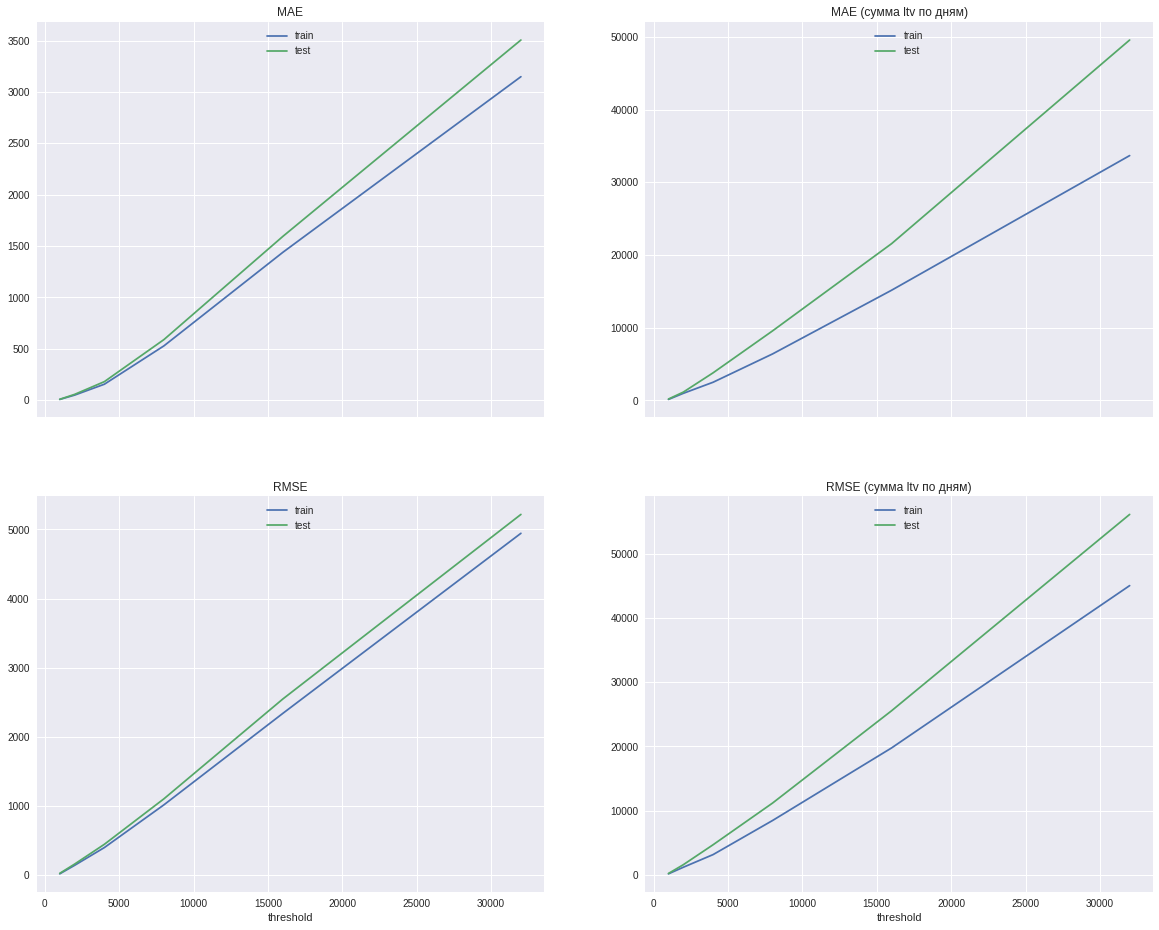

In [94]:
thresholds = np.array([1000 * (2 ** i) for i in range(6)])
mae_train = np.zeros_like(thresholds)
mae_test = np.zeros_like(thresholds)
rmse_train = np.zeros_like(thresholds)
rmse_test = np.zeros_like(thresholds)

mae_train_sum = np.zeros_like(thresholds)
mae_test_sum = np.zeros_like(thresholds)
rmse_train_sum = np.zeros_like(thresholds)
rmse_test_sum = np.zeros_like(thresholds)

ss = StandardScaler()
est = ExtraTreesRegressor(n_estimators=50, max_depth=8, bootstrap=True)
std_est = Pipeline([("std_scaler", ss), ("estimator", est)])

for i in range(thresholds.size):
    y1 = y.copy()
    y1_test = y_test.copy()
    # ограничение ltv cверху
    t = thresholds[i]
    y1[y1 > t] = t
    y1_test[y1_test > t] = t
    # исключение игроков, которые не платили в течение первой недели
    X1 = X1[payers_revenue_ts.iloc[:, :7].sum(axis=1) != 0]
    y1 = y1[payers_revenue_ts.iloc[:, :7].sum(axis=1) != 0]
    X1_test = X1_test[payers_revenue_ts_test.iloc[:, :7].sum(axis=1) != 0]
    y1_test = y1_test[payers_revenue_ts_test.iloc[:, :7].sum(axis=1) != 0]

    std_est, y_pred, y_pred_test = train_model(X=X1, y=y1, X_test=X1_test, y_test=y1_test, model=std_est)
    
    Y = y1.to_frame().join(payers_regday.to_frame())
    Y["pred"] = y_pred
    Y_test = y1_test.to_frame().join(payers_regday_test.to_frame())
    Y_test["pred"] = y_pred_test
    
    mae_train[i] = mean_absolute_error(Y.revenue, Y.pred)
    mae_test[i] = mean_absolute_error(Y_test.revenue, Y_test.pred)
    rmse_train[i] = rmse(Y.revenue, Y.pred)
    rmse_test[i] = rmse(Y_test.revenue, Y_test.pred)
    
    Y = Y.groupby("regday").sum()
    Y_test = Y_test.groupby("regday").sum()
    
    mae_train_sum[i] = mean_absolute_error(Y.revenue, Y.pred)
    mae_test_sum[i] = mean_absolute_error(Y_test.revenue, Y_test.pred)
    rmse_train_sum[i] = rmse(Y.revenue, Y.pred)
    rmse_test_sum[i] = rmse(Y_test.revenue, Y_test.pred)

f, axes = plt.subplots(2, 2, figsize=(20, 16), sharex='col', sharey=False)
axes[0, 0].plot(thresholds, mae_train, label='train')
axes[0, 0].plot(thresholds, mae_test, label='test')
axes[0, 0].set_title("MAE")
axes[0, 0].legend(loc='upper center', shadow=True)
axes[1, 0].plot(thresholds, rmse_train, label='train')
axes[1, 0].plot(thresholds, rmse_test, label='test')
axes[1, 0].legend(loc='upper center', shadow=True)
axes[1, 0].set_title("RMSE")
axes[1, 0].set_xlabel("threshold")
axes[0, 1].plot(thresholds, mae_train_sum, label='train')
axes[0, 1].plot(thresholds, mae_test_sum, label='test')
axes[0, 1].set_title("MAE (сумма ltv по дням)")
axes[0, 1].legend(loc='upper center', shadow=True)
axes[1, 1].plot(thresholds, rmse_train_sum, label='train')
axes[1, 1].plot(thresholds, rmse_test_sum, label='test')
axes[1, 1].set_title("RMSE (сумма ltv по дням)")
axes[1, 1].legend(loc='upper center', shadow=True)
axes[1, 1].set_xlabel("threshold")
plt.show()

In [95]:
# зависимость ошибки от тестовой недели (модель - ExtraTreesRegressor(n_estimators=50, max_depth=8, bootstrap=True))

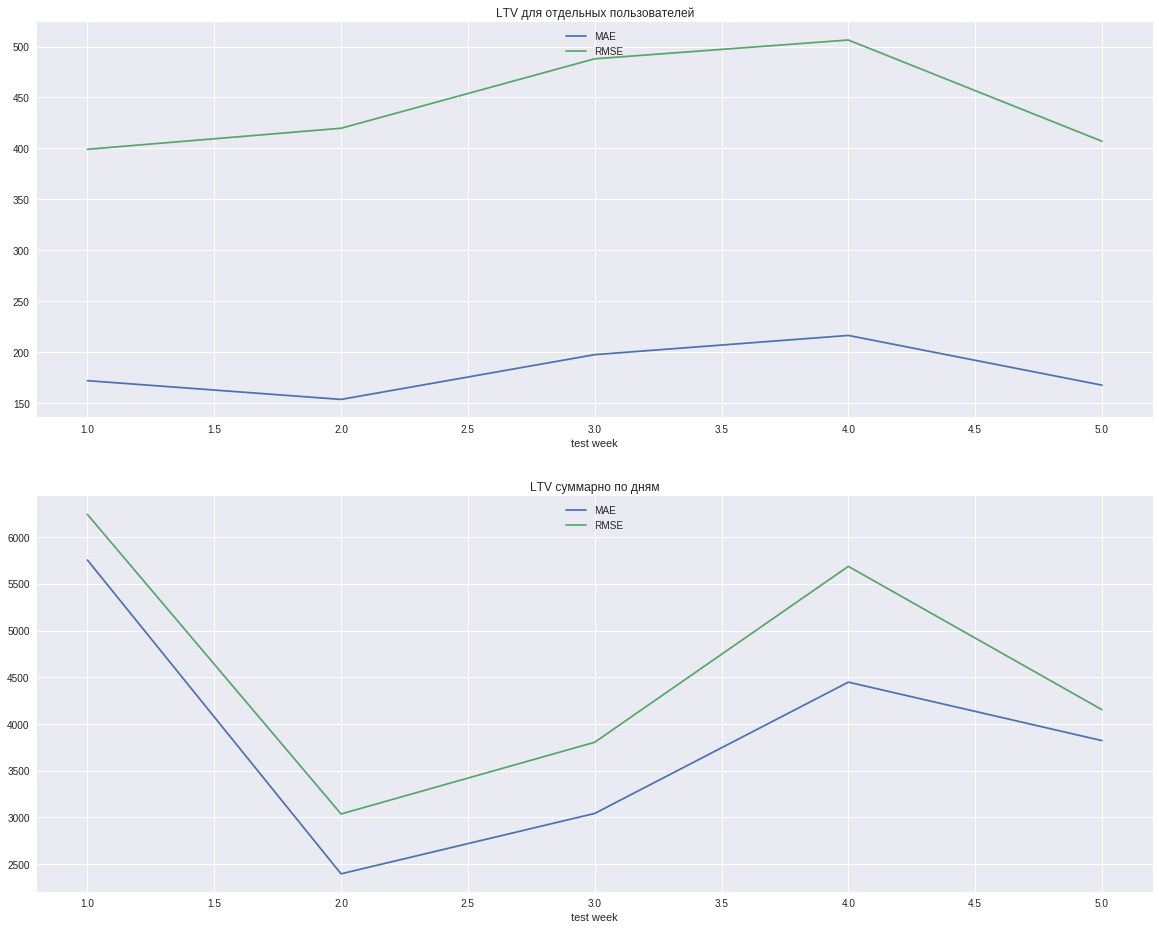

In [98]:
y1 = y.copy()
y1_test = y_test.copy()
# ограничение ltv cверху
t = 4000
y1[y1 > t] = t
y1_test[y1_test > t] = t
# исключение игроков, которые не платили в течение первой недели
X1 = X1[payers_revenue_ts.iloc[:, :7].sum(axis=1) != 0]
y1 = y1[payers_revenue_ts.iloc[:, :7].sum(axis=1) != 0]
X1_test = X1_test[payers_revenue_ts_test.iloc[:, :7].sum(axis=1) != 0]
y1_test = y1_test[payers_revenue_ts_test.iloc[:, :7].sum(axis=1) != 0]

ss = StandardScaler()
est = ExtraTreesRegressor(n_estimators=50, max_depth=8, bootstrap=True)
std_est = Pipeline([("std_scaler", ss), ("estimator", est)])

std_est, y_pred, y_pred_test = train_model(X=X1, y=y1, X_test=X1_test, y_test=y1_test, model=std_est)

Y = y1.to_frame().join(payers_regday.to_frame())
Y["pred"] = y_pred
Y_test = y1_test.to_frame().join(payers_regday_test.to_frame())
Y_test["pred"] = y_pred_test
Y_test["reg_week"] = (Y_test.regday - Y_test.regday.min()) // 7

n_test_weeks = int((Y_test.regday.max() - Y_test.regday.min()) // 7) + 1

week_mae = np.zeros(n_test_weeks)
week_rmse = np.zeros(n_test_weeks)
week_mae_sum = np.zeros(n_test_weeks)
week_rmse_sum = np.zeros(n_test_weeks)

for i in range(n_test_weeks):
    week_mae[i] = mean_absolute_error(Y_test.loc[(Y_test.regday - Y_test.regday.min()) // 7 == i, "revenue"], 
                                      Y_test.loc[(Y_test.regday - Y_test.regday.min()) // 7 == i, "pred"])
    week_rmse[i] = rmse(Y_test.loc[(Y_test.regday - Y_test.regday.min()) // 7 == i, "revenue"], 
                        Y_test.loc[(Y_test.regday - Y_test.regday.min()) // 7 == i, "pred"])
    
Y_test = Y_test.groupby("regday").sum().reset_index()
for i in range(n_test_weeks):
    week_mae_sum[i] = mean_absolute_error(Y_test.loc[(Y_test.regday - Y_test.regday.min()) // 7 == i, "revenue"], 
                                          Y_test.loc[(Y_test.regday - Y_test.regday.min()) // 7 == i, "pred"])
    week_rmse_sum[i] = rmse(Y_test.loc[(Y_test.regday - Y_test.regday.min()) // 7 == i, "revenue"],
                            Y_test.loc[(Y_test.regday - Y_test.regday.min()) // 7 == i, "pred"])
    
f, axes = plt.subplots(2, figsize=(20, 16))
axes[0].plot(np.arange(1, n_test_weeks + 1), week_mae, label='MAE')
axes[0].plot(np.arange(1, n_test_weeks + 1), week_rmse, label='RMSE')
axes[0].set_title("LTV для отдельных пользователей")
axes[0].set_xlabel("test week")
axes[0].legend(loc='upper center', shadow=True)
axes[1].plot(np.arange(1, n_test_weeks + 1), week_mae_sum, label='MAE')
axes[1].plot(np.arange(1, n_test_weeks + 1), week_rmse_sum, label='RMSE')
axes[1].set_title("LTV суммарно по дням")
axes[1].set_xlabel("test week")
axes[1].legend(loc='upper center', shadow=True)
plt.show()

In [97]:
# зависимость ошибки от ограничения LTV и тестовой недели 
# (модель - ExtraTreesRegressor(n_estimators=50, max_depth=8, bootstrap=True))

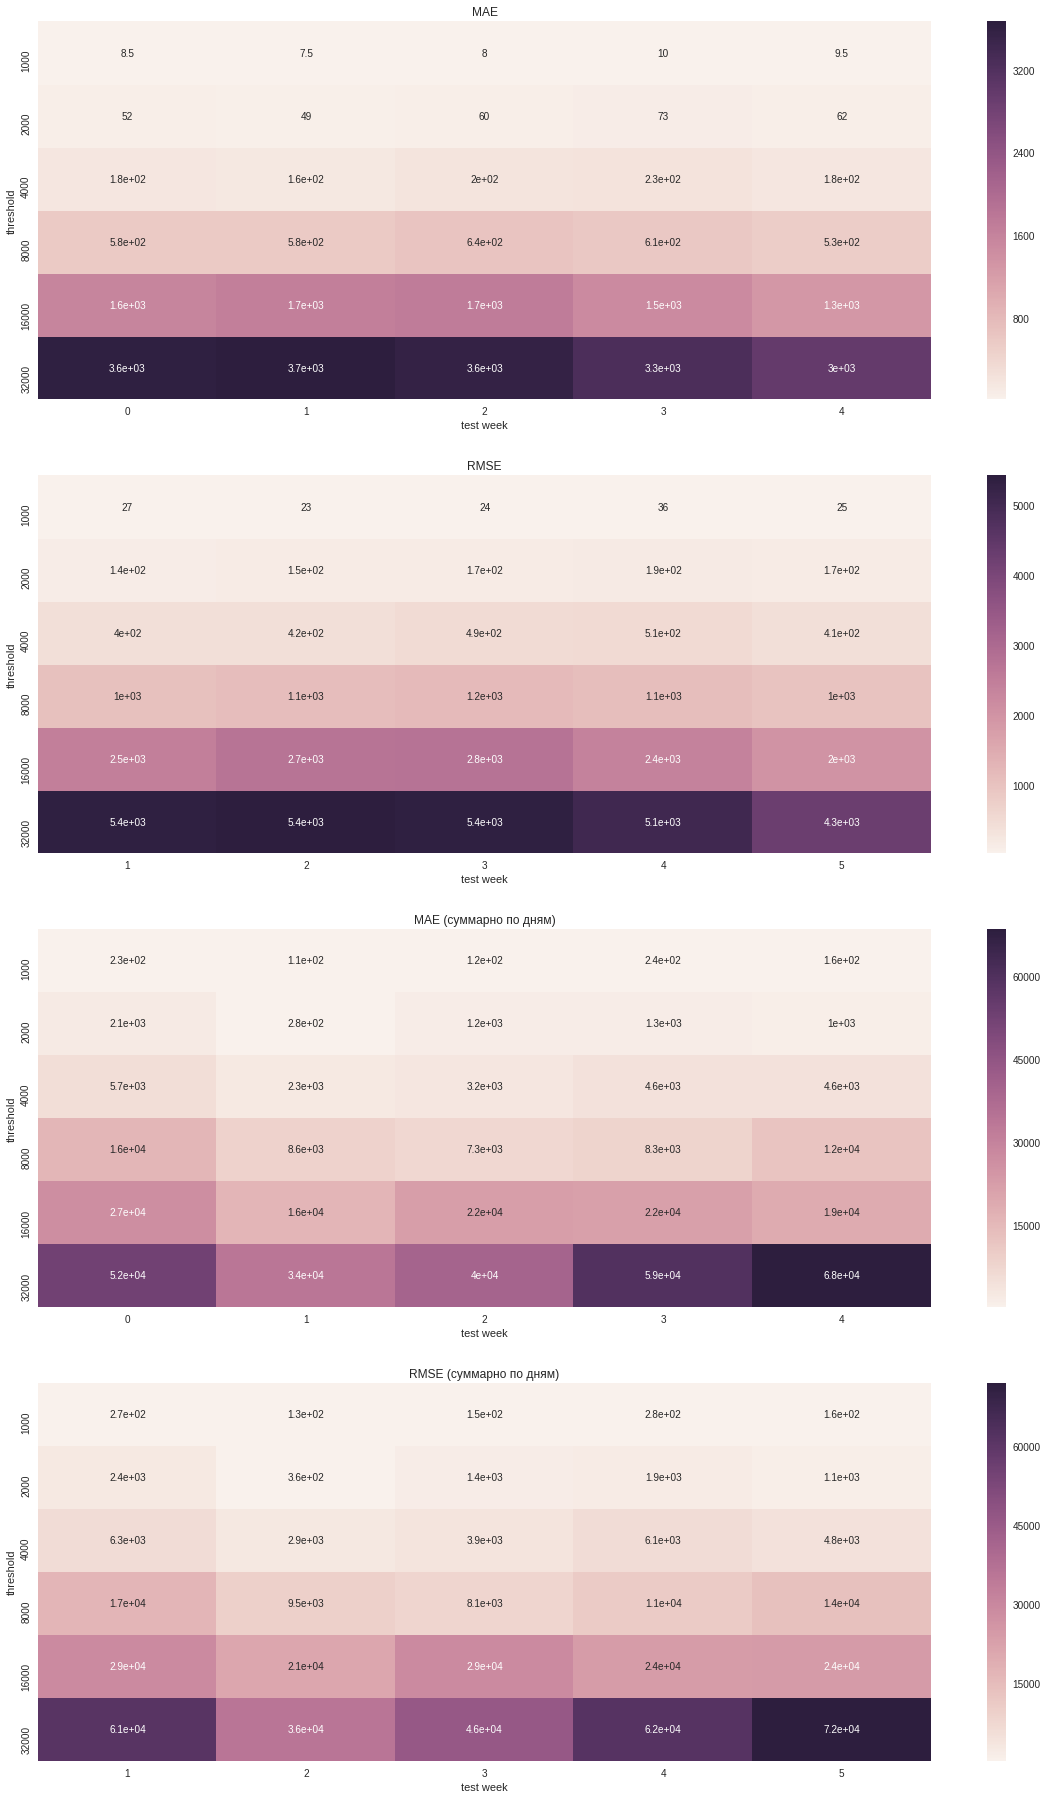

In [100]:
thresholds = np.array([1000 * (2 ** i) for i in range(6)])

n_test_weeks = int((payers_regday_test.max() - payers_regday_test.min()) // 7) + 1
n_test_weeks = 5

week_mae = np.zeros((thresholds.size, n_test_weeks))
week_rmse = np.zeros((thresholds.size, n_test_weeks))
week_mae_sum = np.zeros((thresholds.size, n_test_weeks))
week_rmse_sum = np.zeros((thresholds.size, n_test_weeks))

ss = StandardScaler()
est = ExtraTreesRegressor(n_estimators=50, max_depth=8, bootstrap=True)
std_est = Pipeline([("std_scaler", ss), ("estimator", est)])

for i in range(thresholds.size):
    y1 = y.copy()
    y1_test = y_test.copy()
    # ограничение ltv cверху
    t = thresholds[i]
    y1[y1 > t] = t
    y1_test[y1_test > t] = t
    # исключение игроков, которые не платили в течение первой недели
    X1 = X1[payers_revenue_ts.iloc[:, :7].sum(axis=1) != 0]
    y1 = y1[payers_revenue_ts.iloc[:, :7].sum(axis=1) != 0]
    X1_test = X1_test[payers_revenue_ts_test.iloc[:, :7].sum(axis=1) != 0]
    y1_test = y1_test[payers_revenue_ts_test.iloc[:, :7].sum(axis=1) != 0]
    
    std_est, y_pred, y_pred_test = train_model(X=X1, y=y1, X_test=X1_test, y_test=y1_test, model=std_est)
    
    Y_test = y1_test.to_frame().join(payers_regday_test.to_frame())
    Y_test["pred"] = y_pred_test
    
    for j in range(n_test_weeks):
        week_mae[i, j] = mean_absolute_error(Y_test.loc[(Y_test.regday - Y_test.regday.min()) // 7 == j, "revenue"], 
                                          Y_test.loc[(Y_test.regday - Y_test.regday.min()) // 7 == j, "pred"])
        week_rmse[i, j] = rmse(Y_test.loc[(Y_test.regday - Y_test.regday.min()) // 7 == j, "revenue"], 
                            Y_test.loc[(Y_test.regday - Y_test.regday.min()) // 7 == j, "pred"])
    
    Y_test = Y_test.groupby("regday").sum().reset_index()
    
    for j in range(n_test_weeks):
        week_mae_sum[i, j] = mean_absolute_error(Y_test.loc[(Y_test.regday - Y_test.regday.min()) // 7 == j, "revenue"], 
                                              Y_test.loc[(Y_test.regday - Y_test.regday.min()) // 7 == j, "pred"])
        week_rmse_sum[i, j] = rmse(Y_test.loc[(Y_test.regday - Y_test.regday.min()) // 7 == j, "revenue"],
                                Y_test.loc[(Y_test.regday - Y_test.regday.min()) // 7 == j, "pred"])

f, axes = plt.subplots(4, figsize=(20, 32))
sns.heatmap(week_mae, annot=True, ax=axes[0], yticklabels=thresholds)
axes[0].set_title("MAE")
axes[0].set_xlabel("test week")
axes[0].set_ylabel("threshold")
sns.heatmap(week_rmse, annot=True, ax=axes[1],  xticklabels=np.arange(1, 6), yticklabels=thresholds)
axes[1].set_title("RMSE")
axes[1].set_xlabel("test week")
axes[1].set_ylabel("threshold")
sns.heatmap(week_mae_sum, annot=True, ax=axes[2], yticklabels=thresholds)
axes[2].set_title("MAE (суммарно по дням)")
axes[2].set_xlabel("test week")
axes[2].set_ylabel("threshold")
sns.heatmap(week_rmse_sum, annot=True, ax=axes[3],  xticklabels=np.arange(1, 6), yticklabels=thresholds)
axes[3].set_title("RMSE (суммарно по дням)")
axes[3].set_xlabel("test week")
axes[3].set_ylabel("threshold")